## Bachelor Thesis - Informatik

### Variante 3 :
### Multiclass-Klassifizierung mit 1D Convolutional Neuronal Network
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Beschreibung der zugrunde liegenden Daten :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">



##### ▶️ Installation notwendiger Python-Bibliotheken

In [246]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install -U seaborn-image
#%pip install matplotlib.pyplot
#%pip install scikit-learn

##### ▶️ Importieren notwendiger Python-Bibliotheken

In [247]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
****

In [248]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene/P1L' + label + '.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene/P2L' + label + '.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene/P3L' + label + '.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene/P4L' + label + '.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Unterlisten in jeweils ein Dataframe         #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([proband1, proband2, proband3, proband4]).reset_index(drop=True)

##### ▶️ Umwandlung der Daten in geeignete Formate

In [249]:
##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Labels = all_data[all_data.columns[-1]]
Labels = np.array(Labels).astype('int')
Labels = np.expand_dims(Labels, -1)


##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
Klassen = np.unique(Labels)
Klassen = np.expand_dims(Klassen, -1)
print("Form der Klassen : ", Klassen.shape)


##############################################################
# Features der Gesten auslesen                               #
# Datentyp Pandas Dataframe                                  #
##############################################################
Features = all_data.drop(64, axis=1).copy()
Features = np.array(Features).astype('float32')
Features = Features.reshape(-1,64)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Form der Features : ", Features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Form der Labels : ", Labels.shape)

Form der Klassen :  (4, 1)
Form der Features :  (6064, 64)
Form der Labels :  (6064, 1)


#### ▶️ Normalisierung der Daten

In [250]:
##############################################################
# Datenskalierung mit Z-Score                                #
##############################################################  
sc = StandardScaler()


##############################################################
# Normalisierung durchführen                                 #
# Datentyp Numpy Array                                       #
##############################################################  
Features = sc.fit_transform(Features)
Features = np.expand_dims(Features, -1)

### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [251]:
##############################################################
# Anzahl der Klassen, bzw. der Gesten                        #
# Fixwert 4                                                  #
##############################################################
num_classes = Klassen.size


##############################################################
# 64 x 1 Matrix --> 1D Arrays für CNN-Modell                 #
##############################################################
input_shape = (64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.4, random_state = 100) # type: ignore


##############################################################
# Konvertieren nach Float                                    #
##############################################################
X_train = X_train.astype("float32")
X_test = X_test.astype("float32") 


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print()
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print()
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Form der Training-Features :  (3638, 64, 1)
Form der Test-Features :  (2426, 64, 1)
Form der Training-Labels :  (3638, 1)
Form der Test-Labels :  (2426, 1)

6064 Gesamt-Features
3638 Training-Features
2426 Test-Features

6064 Gesamt-Labels
3638 Training-Labels
2426 Test-Labels


#### ▶️ Modellarchitektur<br>

In [252]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 64
epochs = 16

initializer='glorot_uniform'


##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv1D(64, 4, input_shape=input_shape, kernel_initializer=initializer))
model.add(layers.Activation('relu'))

model.add(layers.Conv1D(64, 4))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())

model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dense(num_classes, activation = 'softmax'))

# Modellparameter ausgeben
model.summary()

c:\Users\Gizmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)              │ (None, 61, 64)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 61, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 58, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 58, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 3712)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │       237,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,660 (994.77 KB)

 Trainable params: 254,660 (994.77 KB)

 Non-trainable params: 0 (0.00 B)

In [253]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
    ]
)

Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5160 - loss: 1.0806 - val_accuracy: 0.7720 - val_loss: 0.5646 - learning_rate: 0.0010
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7786 - loss: 0.4862 - val_accuracy: 0.7857 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8528 - loss: 0.3561 - val_accuracy: 0.8297 - val_loss: 0.3954 - learning_rate: 0.0010
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8739 - loss: 0.3135 - val_accuracy: 0.8324 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9055 - loss: 0.2492 - val_accuracy: 0.8489 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9357 - loss: 0.1855 - val_accuracy: 0.8571 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9522 - loss: 0.1478 - val_accuracy: 

### ▶️ Ausgabe der Funktionen für Verlust und Genauigkeit

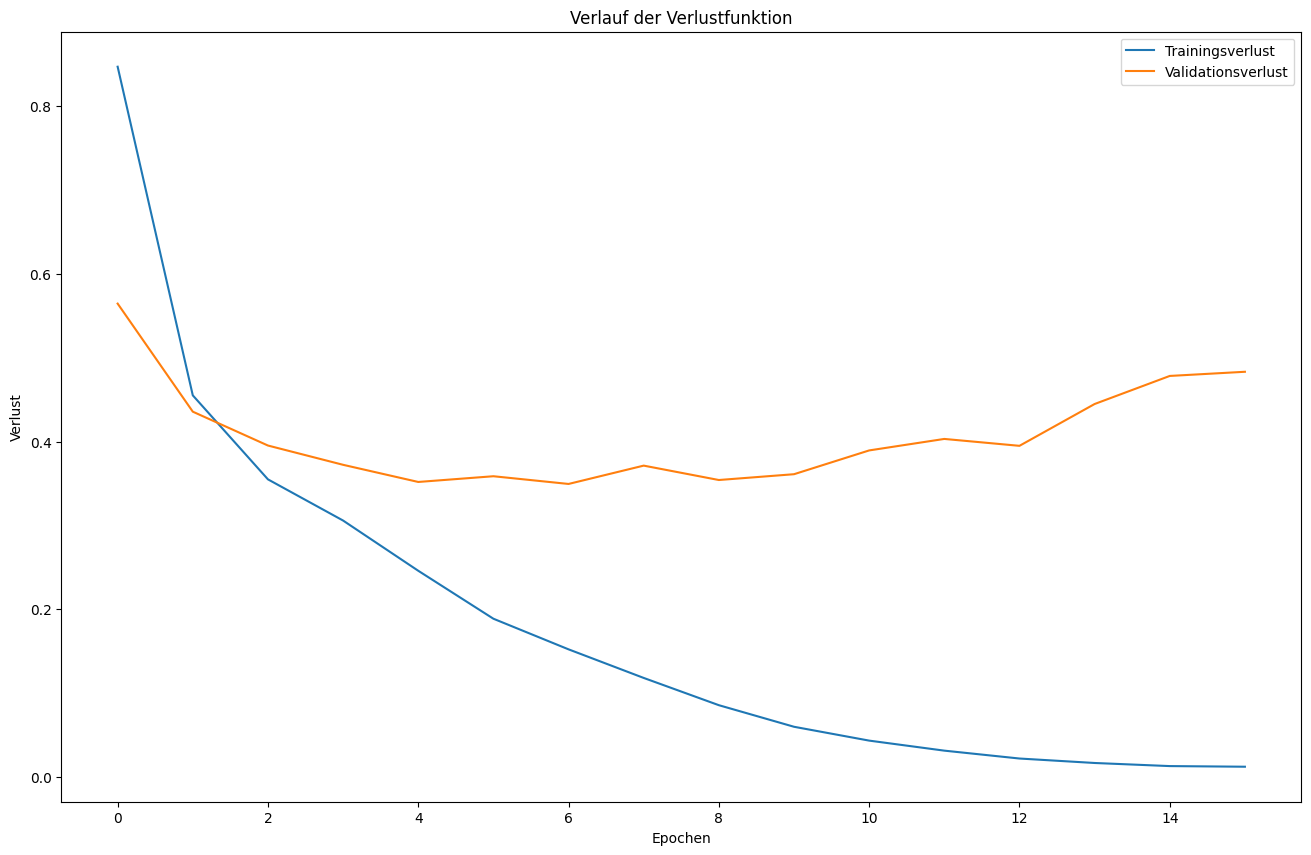

In [254]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

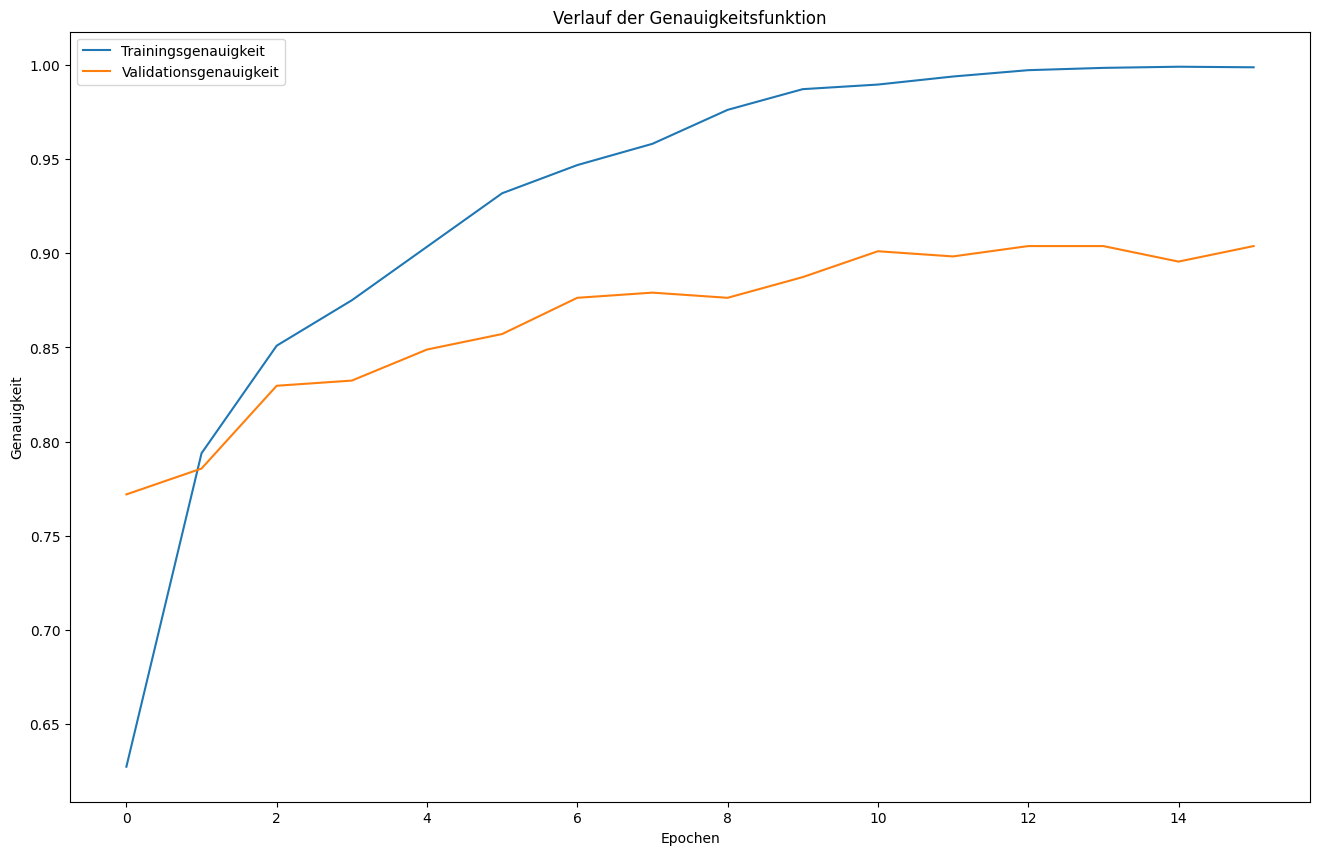

In [255]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Scores zur Beurteilung der Modellqualität 

In [256]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Testverlust :", score[0])
print("Testgenauigkeit :", score[1])

Testverlust : 0.43987321853637695
Testgenauigkeit : 0.8882935047149658


In [257]:
y = model.predict(np.array(Features))[50]
print("Es handelt sich um Geste : " + str(np.argmax(y)))

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Es handelt sich um Geste : 0


### ▶️ Metriken zur Beurteilung der Modellqualität 

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


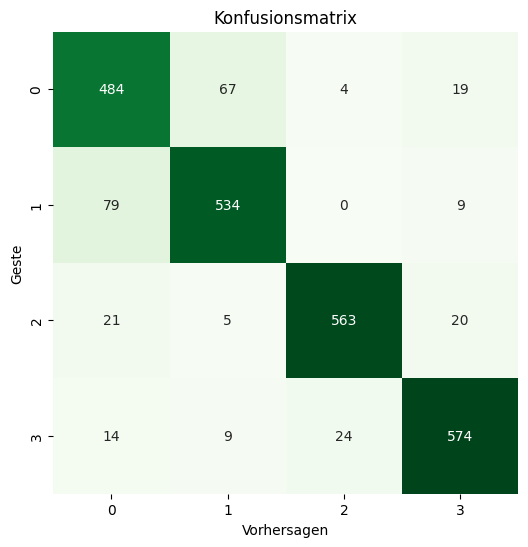

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       574
           1       0.87      0.86      0.86       622
           2       0.95      0.92      0.94       609
           3       0.92      0.92      0.92       621

    accuracy                           0.89      2426
   macro avg       0.89      0.89      0.89      2426
weighted avg       0.89      0.89      0.89      2426



In [258]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))